**LOAD DATASET**

In [22]:
from google.colab import files
uploaded = files.upload()

Saving Maternal Health Risk Data Set.csv to Maternal Health Risk Data Set (1).csv


**PRE-PROCESSING FUNCTION**

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def load_data(file_path):
    #Loads dataset from a CSV file
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df):
    # Handles missing values, encodes labels, and removes outliers
    df["RiskLevel"] = df["RiskLevel"].replace({"high risk": 2, "mid risk": 1, "low risk": 0})

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    df_no_outliers = df.copy()
    for column in df.columns:
        lower_bound = Q1[column] - 1.5 * IQR[column]
        upper_bound = Q3[column] + 1.5 * IQR[column]
        df_no_outliers[column] = np.where(df[column] < lower_bound, lower_bound, df_no_outliers[column])
        df_no_outliers[column] = np.where(df[column] > upper_bound, upper_bound, df_no_outliers[column])

    return df_no_outliers

def split_and_balance_data(df):
    # Splits dataset into training, validation, and test sets, and applies SMOTE
    X = df.drop('RiskLevel', axis = 1)
    y = df['RiskLevel']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

    smote = SMOTE(sampling_strategy = {0: 406}, random_state = 42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_resampled_scaled, X_val_scaled, X_test_scaled, y_train_resampled, y_val, y_test, scaler

**MODEL FUNCTION**

<ipython-input-24-b3d9de8c8dcf>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["RiskLevel"] = df["RiskLevel"].replace({"high risk": 2, "mid risk": 1, "low risk": 0})



Model Performance Summary:
Training Accuracy: 0.9395
Validation Accuracy: 0.8528
Test Accuracy: 0.8325

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.83      0.84        81
         1.0       0.80      0.76      0.78        67
         2.0       0.85      0.93      0.89        55

    accuracy                           0.83       203
   macro avg       0.83      0.84      0.83       203
weighted avg       0.83      0.83      0.83       203



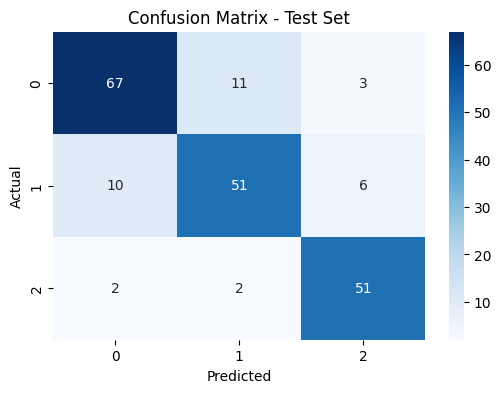

Model and scaler saved successfully in models!


In [25]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dataset_path = "Maternal Health Risk Data Set.csv"
df = load_data(dataset_path)
df_cleaned = preprocess_data(df)
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_balance_data(df_cleaned)

def train_model(X_train, y_train):
    #Trains a RandomForest model and returns the trained model
    model = RandomForestClassifier(n_estimators = 100, random_state = 42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):
    #Evaluates the model's accuracy and displays a confusion matrix
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    val_accuracy = accuracy_score(y_val, model.predict(X_val))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    print("\nModel Performance Summary:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("\nClassification Report:\n", classification_report(y_test, model.predict(X_test), zero_division = 1))

    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    plt.figure(figsize = (6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap = "Blues")
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def save_model(model, scaler, model_dir="models"):
    # Saves the trained model and scaler inside the maternAI/model directory
    os.makedirs(model_dir, exist_ok = True)
    joblib.dump(model, os.path.join(model_dir, "random_forest_maternal_health.pkl"))
    joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
    print(f"Model and scaler saved successfully in {model_dir}!")

model = train_model(X_train, y_train)
evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)
save_model(model, scaler)

**PREDICTION FUNCTION**

In [28]:
import numpy as np
import pandas as pd
import joblib

def load_model(model_path = "models/random_forest_maternal_health.pkl", scaler_path = "models/scaler.pkl"):
    # Loads the trained model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    print("Model and scaler loaded successfully!")
    return model, scaler

def make_prediction(model, scaler, sample):
    #Takes a raw input sample, applies scaling, and predicts the risk level
    feature_names = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]

    sample_df = pd.DataFrame([sample], columns = feature_names)
    sample_scaled = scaler.transform(sample_df)

    predicted_risk_numeric = model.predict(sample_scaled)[0]
    risk_mapping = {0: "low risk", 1: "mid risk", 2: "high risk"}

    return risk_mapping[predicted_risk_numeric]

if __name__ == "__main__":
    model, scaler = load_model()
    sample = [25, 140, 80, 6.5, 98, 80]  # Example input, You can experiment with different values
    predicted_risk = make_prediction(model, scaler, sample)
    print(f"Predicted Risk Level: {predicted_risk}")

Model and scaler loaded successfully!
Predicted Risk Level: high risk
